# Library Import

In [1]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path

# Configuration Reading from File

In [3]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
name = 'odd_run4.odd_df2_4fop'
datName = name + '.dat'

fileName = dirName + datName

In [4]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [5]:
noperators=5 #number of operators (VA - AV - SP - PS - TT~)

verbose=True #True to print more output

In [6]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 5 integers, 5x4=20byte, and 2 double, 2x8=16byte
    header_size= 6*4 +2*8

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type, check_gauge_inv, random_conf, csw, cf = struct.unpack("iiiiiidd", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    k3=['']*ncorr
    k4=['']*ncorr
    mu1=['']*ncorr
    mu2=['']*ncorr
    mu3=['']*ncorr
    mu4=['']*ncorr
    typeA=['']*ncorr
    typeB=['']*ncorr
    x0=['']*ncorr
    z0=['']*ncorr

    
    #each correlator has an header of size given by 8x8 + 4x4 = 80byte
    corr_header_size = 8*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], k3[i], k4[i], mu1[i], mu2[i], mu3[i], mu4[i], typeA[i], typeB[i], x0[i], z0[i] = struct.unpack("ddddddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    conn_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #connected correlators
    disc_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #disconnected correlators

        

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          nnoise_A  *  nnoise_B  *  time lenght of lattice * noperators   * ncorrelators * 2 (diagrams=connected+disconnected)  * 2 (re+im) * 8 (sizeof(double))  + sizeof(int) (= conf_number)
    conf_len = nnoise    *   nnoise   *  tvals                  * noperators   * ncorr        * 2                                    * 2         * 8                    + 4
    #                     ncorr * nnoise * tvaks * 2 (x+z 2point corr) * 2 (re+im) * 8 (sizeof(double))
    conf_len = conf_len + ncorr * nnoise * tvals * 2                   * 2         * 8

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent), conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        conn_corr.fill(complex(0,0))
        disc_corr.fill(complex(0,0))

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):

            #reading of chunk with conn corr
            
            #loop over the operators (...noperators blocs of...)
            for op in range(noperators):
                #loop over time values (...tvals blocks of...)
                for t in range(tvals):
                    #loop over noiseB vectors (...nnoise blocks of...)
                    for noiseB in range(nnoise):
                        #loop over noiseA vectors (...nnoise blocks of...)
                        for noiseA in range(nnoise):
                    
                            #reading of re and im part of correlators   (...complex numbers)
                            
                            #connected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*2*ic)))

                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            conn_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            #disconnected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*(2*ic+1))))

                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            disc_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            ############# new reading #########

                            #start_reading  = start_conf + 4 + 2 * 2*8 * (noiseA + nnoise*(noiseB + nnoise*(t + tvals*(op + noperators*ic ) ) ) )

                            #re_con, im_con, re_disc, im_disc = struct.unpack("dddd",fileContent[start_reading:start_reading+2*2*8])
                            #conn_corr[ic,op,t,noiseB,noiseA] = complex(re_con,im_con)
                            #disc_corr[ic,op,t,noiseB,noiseA] = complex(re_disc,im_disc)

        #store of correlators associated to the given configuration
        if str(conf_number) not in conf_dict.keys():
            conf_dict[str(conf_number)] = (conn_corr.copy(),disc_corr.copy())
        else:
            conf_dict[str(conf_number)+"_GaugeInvCheck"] = (conn_corr.copy(),disc_corr.copy())

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [7]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())[0::1+check_gauge_inv]
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)

In [8]:
#creation of a numpy array with all the correlators
all_correlators = np.empty(shape=(nconf,2,ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #2 is for connected and disconnected
for iconf,nameconf in enumerate(conf_names):
    all_correlators[iconf] = conf_dict[nameconf]

In [9]:
if verbose:
    print("(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)")
    print(np.shape(all_correlators))

(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)
(701, 2, 1, 5, 32, 15, 15)


# Data Anlysis

## Average over Noise

In [10]:
all_correlators_navg = all_correlators.mean(axis=-1).mean(axis=-1)

if verbose:
    print("(nconf, pieces, ncorrelators, noperators, tvals)")
    print(np.shape(all_correlators_navg))

(nconf, pieces, ncorrelators, noperators, tvals)
(701, 2, 1, 5, 32)


## Sum of Connected and Disconnected piece

In [11]:
all_correlators_navg_tot = all_correlators_navg[:,0,:,:,:] + all_correlators_navg[:,1,:,:,:]

if verbose:
    print("(nconf, ncorrelators, noperators, tvals)")
    print(np.shape(all_correlators_navg_tot))

(nconf, ncorrelators, noperators, tvals)
(701, 1, 5, 32)


## Optional: delete outlier configurations

In [12]:
#bad_conf = [i for i in range(nconf) if ( np.abs(all_correlators_navg_tot[i,0,:,:].imag-jack_mean[0,:,:].imag) ).mean(axis=-1).mean(axis=-1) > 0.1]

#if verbose:
    #bad_conf
    ##len(bad_conf)

In [13]:
#delate outlier configurations
#all_correlators_navg_tot = all_correlators_navg[:,0,:,:,:] + all_correlators_navg[:,1,:,:,:]
#all_correlators_navg_tot = np.delete(all_correlators_navg_tot,bad_conf,axis=0)

#if verbose:
    #print("(nconf-len(bad_conf), ncorrelators, noperators, tvals)")
    #print(np.shape(all_correlators_navg_tot))

## Creation of jackknife replicates

In [75]:
delta = 1

In [76]:
new_nconf= np.shape(all_correlators_navg_tot)[0]

if verbose:
    print(new_nconf)

701


In [77]:
jack_replicates = np.asarray( [np.delete(all_correlators_navg_tot, list(range(iconf,min(iconf+delta,new_nconf))) ,axis=0).mean(axis=0) for iconf in range(0,new_nconf,delta)] )

if verbose:
    print("(nconf, ncorrelators, noperators, tvals)") #here nconf = number of jack replicates
    print(np.shape(jack_replicates))

(nconf, ncorrelators, noperators, tvals)
(701, 1, 5, 32)


## Calculation of of Jacknife Mean and Standard Deviation

In [78]:
jack_mean = jack_replicates.mean(axis=0)

if verbose:
    print("(ncorrelators, noperators, tvals)")
    print(np.shape(jack_mean))

(ncorrelators, noperators, tvals)
(1, 5, 32)


In [79]:
jack_std = np.sqrt(len(jack_replicates)-1) * np.std(jack_replicates.imag,axis=0)

if verbose:
    print("(ncorrelators, noperators, tvals)")
    print(np.shape(jack_std))

(ncorrelators, noperators, tvals)
(1, 5, 32)


In [80]:
#jack_std2 = np.sqrt( (len(jack_replicates)-1)/len(jack_replicates) * np.sum( (jack_replicates.imag[:]-jack_mean.imag)**2, axis=0 ) )

In [81]:
#jack_std-jack_std2

In [82]:
#relative errors
jack_std/jack_mean.imag

/tmp/ipykernel_5509/3191204224.py:2: RuntimeWarning: invalid value encountered in divide
  jack_std/jack_mean.imag


array([[[        nan,  0.01446514,  0.01420039,  0.01401069,
          0.01388032,  0.01346313,  0.01300306,  0.01282208,
          0.01263557,  0.01246407,  0.01233538,  0.01245554,
          0.01231891,  0.01223569,  0.01247483,  0.01254126,
          0.01279003,  0.01298299,  0.01302937,  0.01334045,
          0.01370411,  0.01416122,  0.0145479 ,  0.01485969,
          0.01511144,  0.01544247,  0.0157698 ,  0.01620796,
          0.01648788,  0.01690231,  0.01737401,         nan],
        [        nan, -0.01431571, -0.01936377, -0.01467408,
         -0.01410621, -0.01357486, -0.0131606 , -0.01334845,
         -0.0131037 , -0.01284321, -0.01262933, -0.01279872,
         -0.01243115, -0.0122986 , -0.0123436 , -0.01269403,
         -0.01277919, -0.01295547, -0.01299416, -0.01353282,
         -0.01390334, -0.01428307, -0.01471478, -0.01493915,
         -0.01516379, -0.01520245, -0.0155993 , -0.0157622 ,
         -0.01615078, -0.01678894, -0.01739499,         nan],
        [        nan, 

# Plots

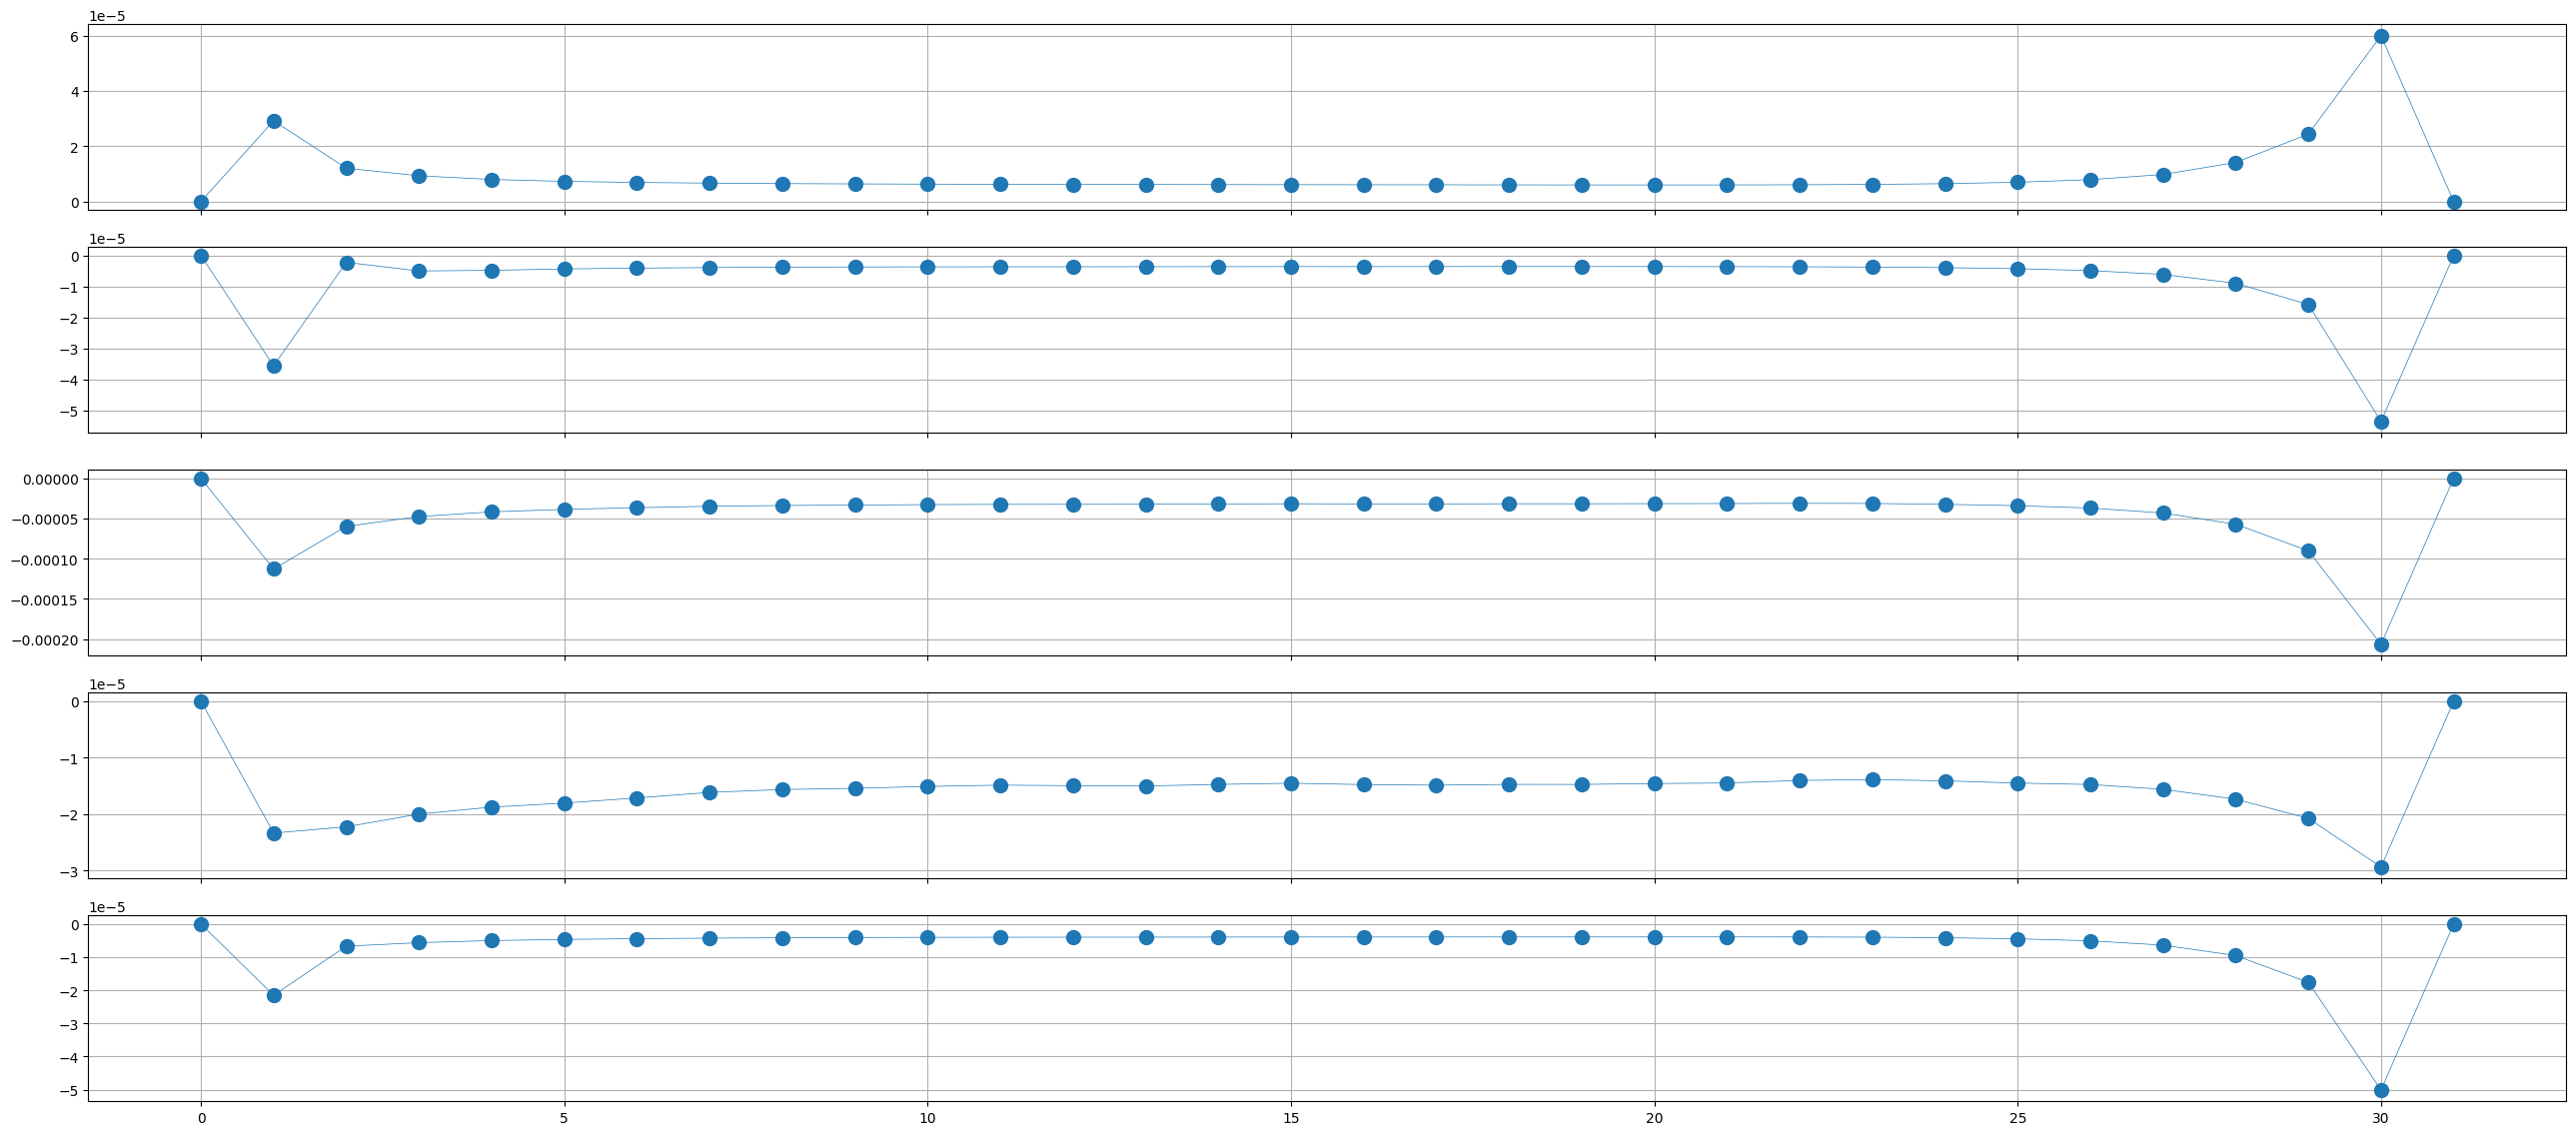

In [83]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax_list = plt.subplots(nrows=noperators, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

for iop in range(noperators):
    _ = ax_list[iop].errorbar(times,jack_mean[0,iop,:].imag,yerr=jack_std[0,iop,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
    ax_list[iop].grid()
        

plt.savefig('prova.png')

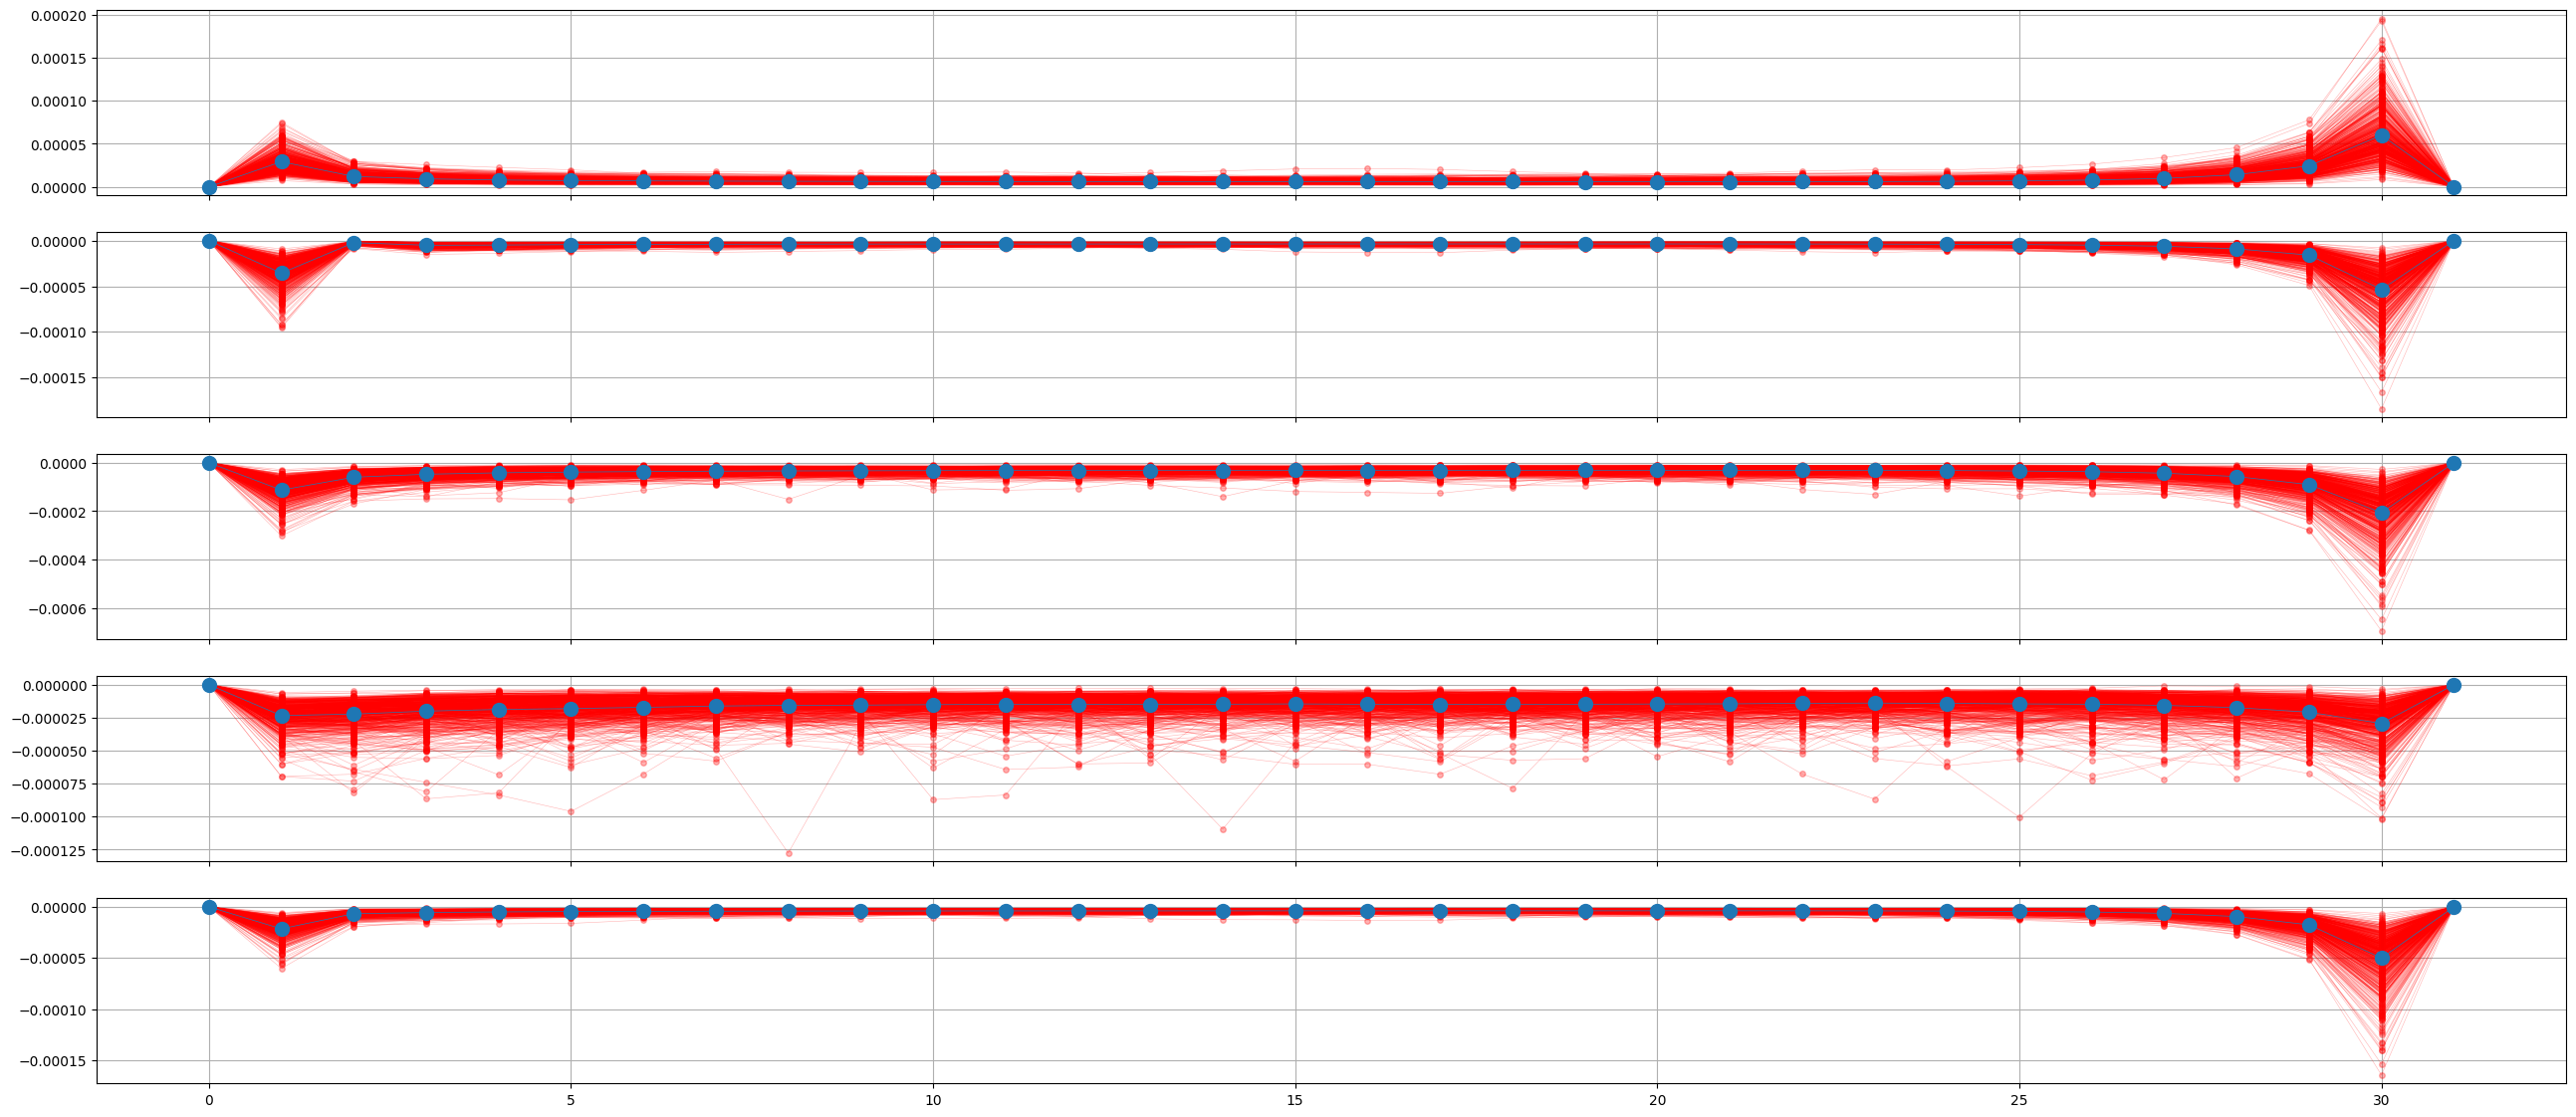

In [84]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax_list = plt.subplots(nrows=noperators, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

for iop in range(noperators):
    _ = ax_list[iop].errorbar(times,jack_mean[0,iop,:].imag,yerr=jack_std[0,iop,:],marker='o',linestyle='solid',markersize=10,linewidth=0.5,elinewidth=2)
    ax_list[iop].grid()
    for ic in range(new_nconf):
         _ = ax_list[iop].plot(times,all_correlators_navg_tot[ic,0,iop,:].imag,'-o',markersize=4,linewidth=0.4,alpha=0.3,color="red")
        

plt.savefig('prova_allconf.png')

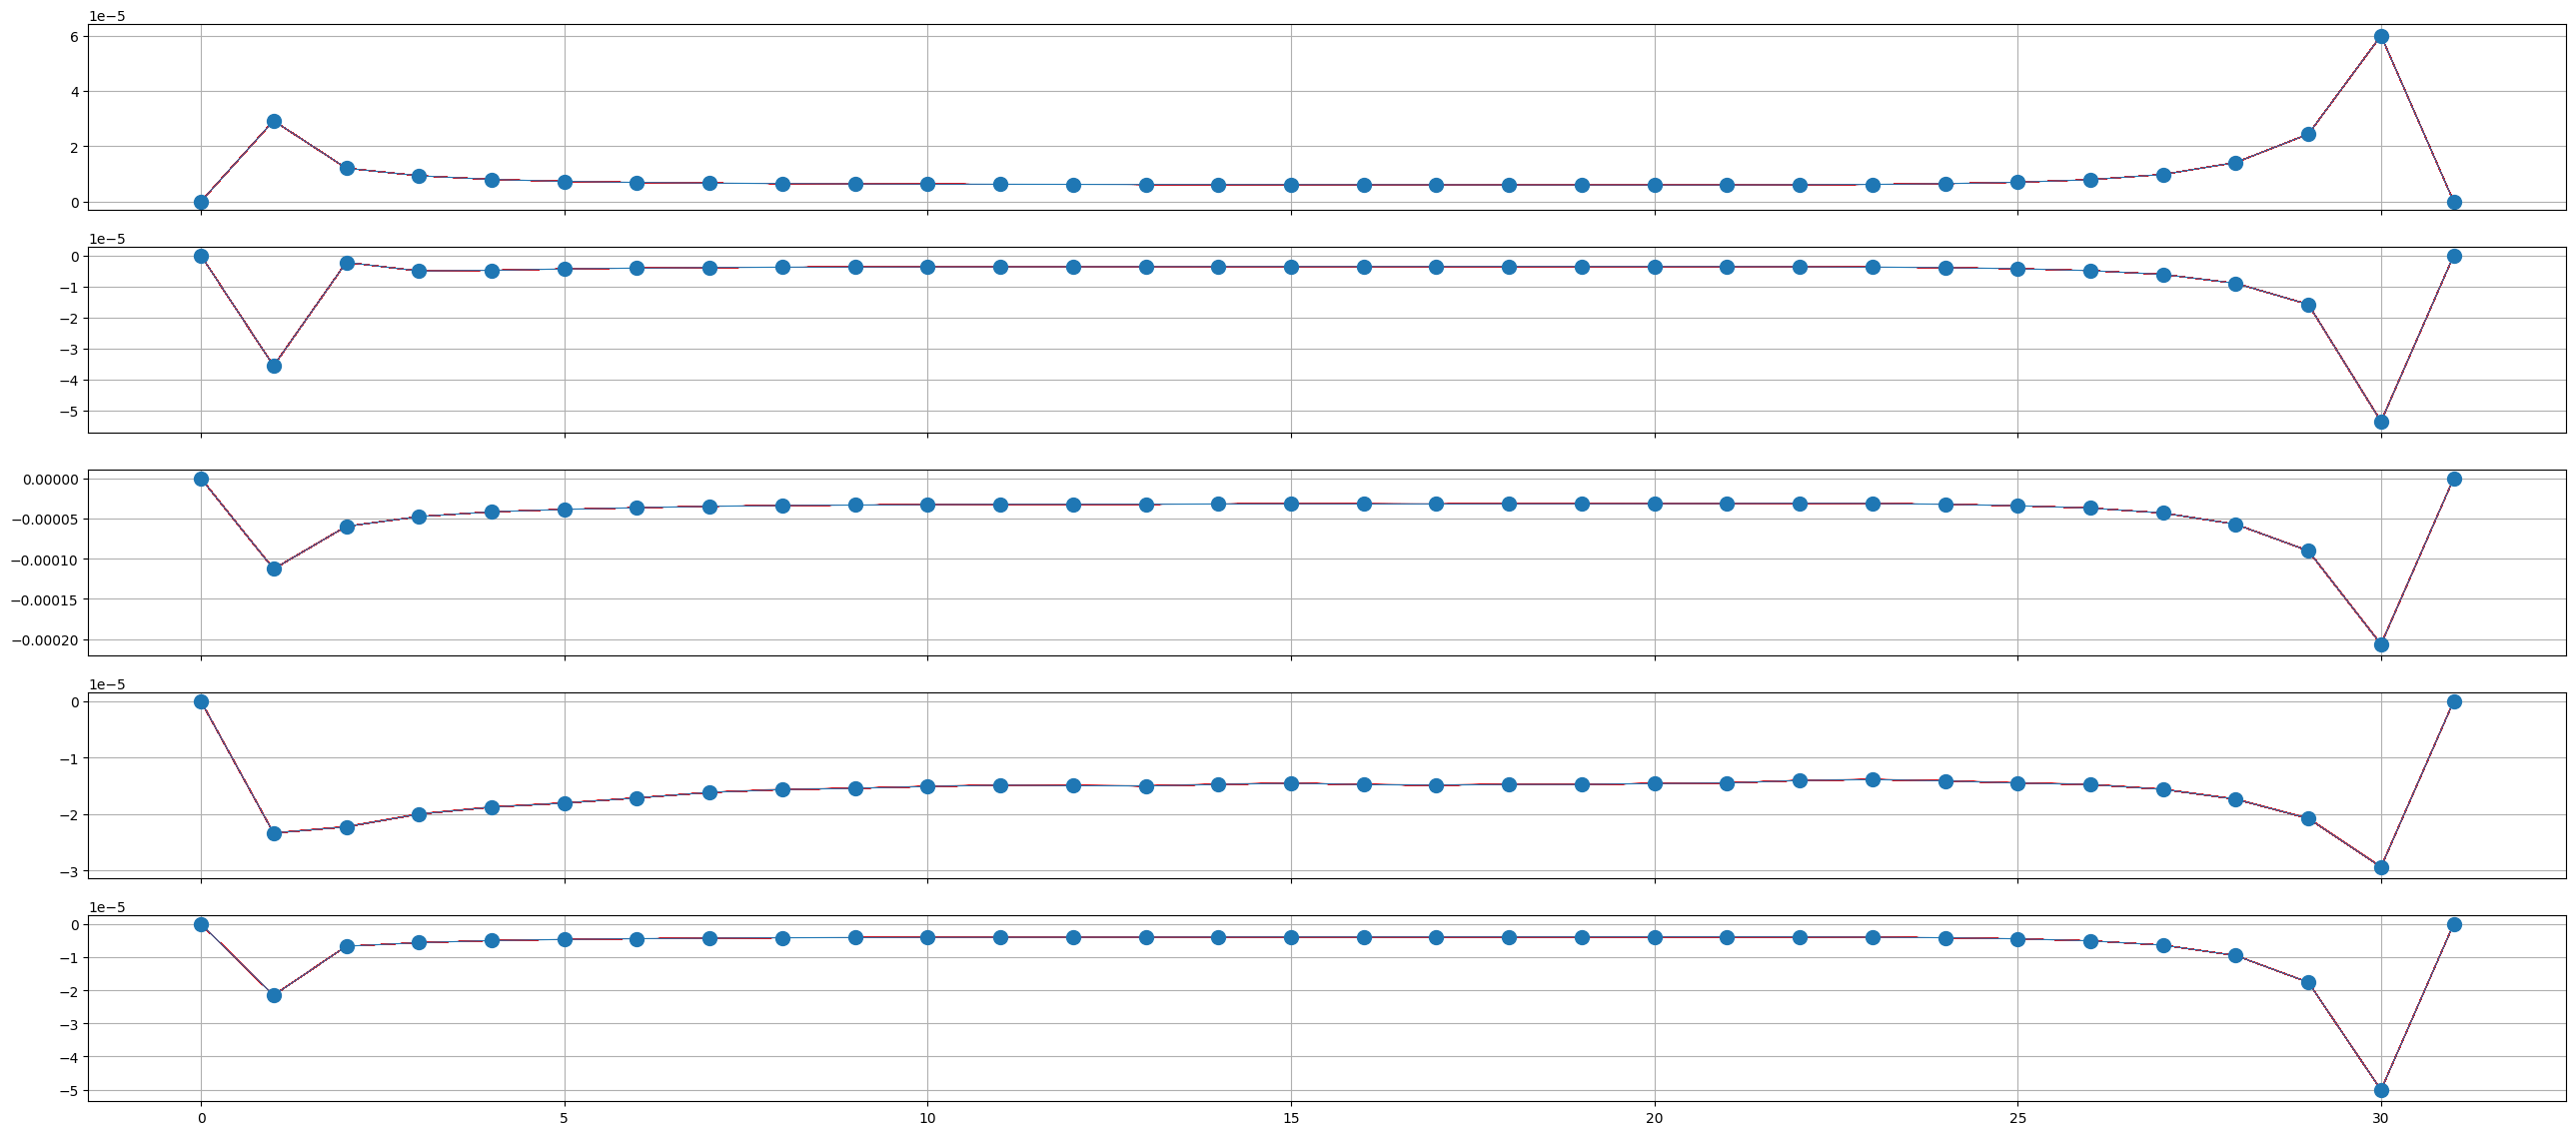

In [85]:
#times on x axis
times = np.arange(0,tvals)

#create figure and axis
fig, ax_list = plt.subplots(nrows=noperators, ncols=1, sharex=True, sharey=False, figsize=(32, 14))

for iop in range(noperators):
    _ = ax_list[iop].errorbar(times,jack_mean[0,iop,:].imag,yerr=jack_std[0,iop,:],marker='o',linestyle='solid',markersize=10,linewidth=0.8,elinewidth=2)
    ax_list[iop].grid()

    for iconf in range(len(jack_replicates)):
        _ = ax_list[iop].plot(times,jack_replicates[iconf,0,iop,:].imag,'-o',markersize=7,linewidth=0.5,alpha=0.4,color="red")

plt.savefig('prova_all.png')